In [129]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from gensim.models import Word2Vec

import nlpaug
# import nlpaug.augmenter.text as nat
# import nlpaug.augmenter.text as nat
import nlpaug.augmenter.word.word_embs as nat
import random

import os
import glob



df = pd.read_csv('deceptive-opinion.csv')
pd.set_option('display.max_colwidth', None)







In [130]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (however, we left on a Sunday morning, not exactly a high traffic time although it was a Bears homegame day, so a bit busier than usual I would think). No problems at all and the best part is that we got a rate of $100 through Hotwire, a downright steal for this area of Chicago and the quality of the hotel. \n"
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,"Problems started when I booked the InterContinental Chicago online at the hotel's site, and got a server error. Somehow I managed to get my reservation, and wish I had looked elsewhere on this great Chicago street, filled with plenty of other options. The server errors continued at check in and didn't let up. I was on a holiday weekend, but far too many others must have been pushy conventioneers, and I had trouble getting served. The hotel is enormous and doesn't give a sense of comfort. The health facilities are also just too big, so noisy and crowded. And Internet access was $18 a day, kind of surprising when I can go

In [131]:
df[df.isnull()].count()

deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64

<AxesSubplot:xlabel='deceptive', ylabel='count'>

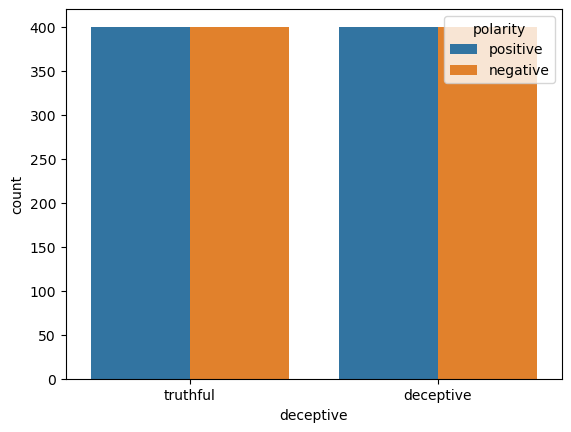

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['deceptive'], hue='polarity', data = df)

In [133]:
df=df.drop(['hotel'],axis=1)


In [134]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string 
def text_cleaning(text):
    '''
        Make text lowercase, remove text in square brackets, remove link, remove special characters, 
        and remove words containing numbers.
    '''
    
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('\\W'," ", text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text


In [135]:
df['text']=df['text'].apply(text_cleaning)


In [136]:
df

,deceptive,polarity,source,text
0,truthful,positive,TripAdvisor,we stayed for a one night getaway with family on a thursday triple aaa rate of was a steal floor room complete with plasma tv bose stereo voss and evian water and gorgeous bathroom no tub but was fine for us concierge was very helpful you cannot beat this location only flaw was breakfast was pricey and service was very very slow for four kids and four adults on a friday morning even though there were only two other tables in the restaurant food was very good so it was worth the wait i would return in a heartbeat a gem in chicago
1,truthful,positive,TripAdvisor,triple a rate with upgrade to view room was less than which also included breakfast vouchers had a great view of river lake wrigley bldg tribune bldg most major restaurants shopping sightseeing attractions within walking distance large room with a very comfortable bed
2,truthful,positive,TripAdvisor,this comes a little late as i m finally catching up on my reviews from the past several months a dear friend and i stayed at the hyatt regency in late october for one night while visiting a friend and her husband from out of town this hotel is perfect imo easy check in and check out lovely clean comfortable rooms with great views of the city i know this area pretty well and it s very convenient to many downtown chicago attractions we had dinner and went clubing with our friends around division st we had no problems getting cabs back and forth to the hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel parking as is usual for chicago was expensive but we were able to get our car out quickly however we left on a sunday morning not exactly a high traffic time although it was a bears homegame day so a bit busier than usual i would think no problems at all and the best part is that we got a rate of through hotwire a downright steal for this area of chicago and the quality of the hotel
3,truthful,positive,TripAdvisor,the omni chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on michigan avenue while this address in chicago requires a high level of quality the omni delivers check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in chicago even the standard room has a separate living area and work desk the fitness center has free weights weight machines and two rows of cardio equipment i shared the room with others and did not feel cramped in any way all in all a great property
4,truthful,positive,TripAdvisor,i asked for a high floor away from the elevator and that is what i got the room was pleasantly decorated functional and very clean i didn t need a whole lot of service but when i did they were pleasant and prompt i used the fitness center which was well equipped and everything was in working order it is in a great location at one end of the michigan avenue shopping district
...,...,...,...,...
1595,deceptive,negative,MTurk,problems started when i booked the intercontinental chicago online at the hotel s site and got a server error somehow i managed to get my reservation and wish i had looked elsewhere on this great chicago street filled with plenty of other options the server errors continued at check in and didn t let up i was on a holiday weekend but far too many others must have been pushy conventioneers and i had trouble getting served the hotel is enormous and doesn t give a sense of comfort the health facilities are also just too big so noisy and crowded and internet access was a day kind of surprising when i can go around the corner to a starbucks next time i ll pick a more intimate place nearby without so many server errors
1596,deceptive,negative,MTurk,the amalfi hotel has a beautiful website and interior decorating but

In [137]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/deth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [138]:
sentences=df['text'].values
y=df['deceptive'].values


In [139]:
y

array(['truthful', 'truthful', 'truthful', ..., 'deceptive', 'deceptive',
       'deceptive'], dtype=object)

In [140]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

In [141]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [142]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,y, test_size=0.2, shuffle=True,
                                                                    random_state=1000)




tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences_train)

x_train_sequences = tokenizer.texts_to_sequences(sentences_train)
x_test_sequences = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

x_train = pad_sequences(x_train_sequences,padding = 'post', maxlen=maxlen)
x_test = pad_sequences(x_test_sequences,padding = 'post', maxlen=maxlen)


# word2vec_model = Word2Vec(x_train_sequences, size=100, window=5, min_count=1, workers=4)
word2vec_model = Word2Vec(x_train_sequences, vector_size=200, window=5, min_count=1, workers=4)


# embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
# for word, i in tokenizer.word_index.items():
#     if word in word2vec_model:
#         embedding_matrix[i] = word2vec_model[word]

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]



In [144]:
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import SpatialDropout1D



model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(pool_size=3))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(x_train, y_train, epochs=20, batch_size=32)
predictions = np.round(model.predict(x_test))
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)


Epoch 1/20
40/40 [==============================] - 4s 40ms/step - loss: 0.6937 - accuracy: 0.5023
Epoch 2/20
40/40 [==============================] - 2s 39ms/step - loss: 0.6935 - accuracy: 0.5016
Epoch 3/20
40/40 [==============================] - 2s 39ms/step - loss: 0.6935 - accuracy: 0.4695
Epoch 4/20
40/40 [==============================] - 2s 39ms/step - loss: 0.6934 - accuracy: 0.4789
Epoch 5/20
40/40 [==============================] - 2s 41ms/step - loss: 0.6933 - accuracy: 0.4820
Epoch 6/20
40/40 [==============================] - 2s 41ms/step - loss: 0.6932 - accuracy: 0.5008
Epoch 7/20
40/40 [==============================] - 2s 39ms/step - loss: 0.6932 - accuracy: 0.5023
Epoch 8/20
40/40 [==============================] - 2s 39ms/step - loss: 0.6932 - accuracy: 0.4891
Epoch 9/20
40/40 [==============================] - 2s 39ms/step - loss: 0.6932 - accuracy: 0.5023
Epoch 10/20
40/40 [==============================] - 2s 40ms/step - loss: 0.6934 - accuracy: 0.4867
Epoch 11/